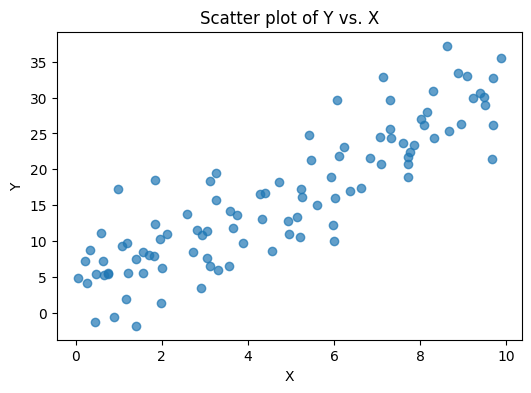

In [1]:
# simulate data & scatter plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
n = 100
X = np.random.uniform(0, 10, size=n)
error = np.random.normal(0, 5, size=n)
Y = 2 + 3*X + error

df = pd.DataFrame({'X': X, 'Y': Y})

plt.figure(figsize=(6,4))
plt.scatter(df['X'], df['Y'], alpha=0.7)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of Y vs. X')
plt.show()


In [2]:
# fit OLS regression with statsmodels
import statsmodels.api as sm

X_sm = sm.add_constant(df['X'])       # add intercept
model = sm.OLS(df['Y'], X_sm).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     326.7
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           5.66e-33
Time:                        03:26:38   Log-Likelihood:                -292.09
No. Observations:                 100   AIC:                             588.2
Df Residuals:                      98   BIC:                             593.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0755      0.851      3.612      0.0

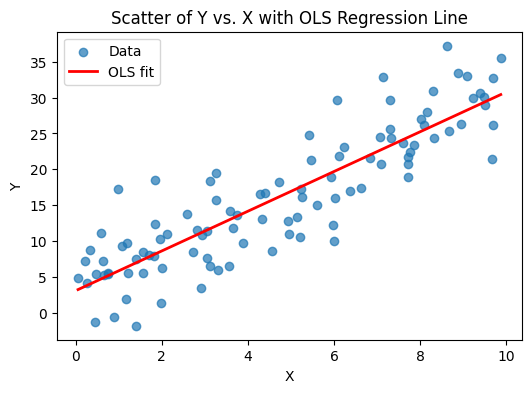

In [3]:
plt.figure(figsize=(6,4))
plt.scatter(df['X'], df['Y'], alpha=0.7, label='Data')
# Create a smooth line over the range of X
x_vals = np.linspace(df['X'].min(), df['X'].max(), 100)
y_vals = model.params['const'] + model.params['X'] * x_vals
plt.plot(x_vals, y_vals, color='red', lw=2, label='OLS fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter of Y vs. X with OLS Regression Line')
plt.legend()
plt.show()

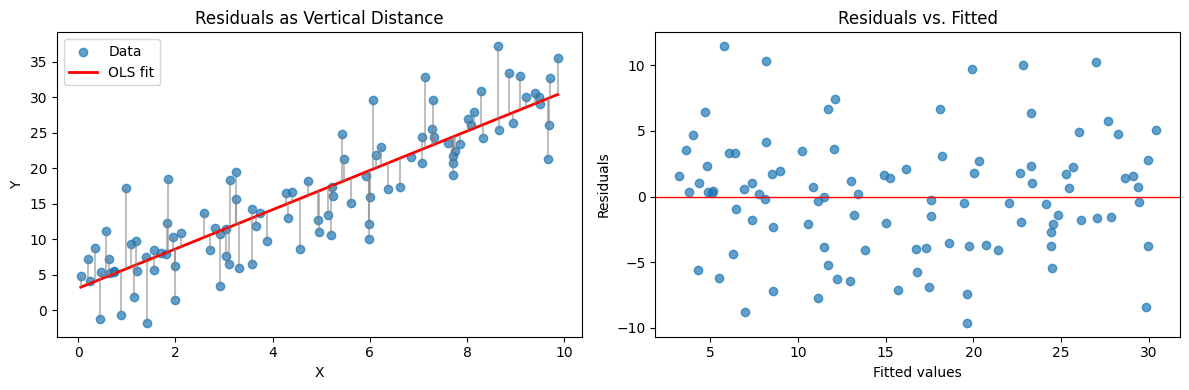

In [4]:
# visualize residuals as vertical distances and residuals vs. fitted
import numpy as np
import matplotlib.pyplot as plt

# Recompute the regression line for plotting
x_vals = np.linspace(df['X'].min(), df['X'].max(), 100)
y_vals = model.params['const'] + model.params['X'] * x_vals

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Panel 1: residuals as vertical distances
axes[0].scatter(df['X'], df['Y'], alpha=0.7, label='Data')
axes[0].plot(x_vals, y_vals, color='red', lw=2, label='OLS fit')
for xi, yi, fi in zip(df['X'], df['Y'], model.fittedvalues):
    axes[0].vlines(xi, yi, fi, color='gray', alpha=0.5)
axes[0].set_title('Residuals as Vertical Distance')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].legend()

# Panel 2: classic residuals vs. fitted plot
axes[1].scatter(model.fittedvalues, model.resid, alpha=0.7)
axes[1].axhline(0, color='red', lw=1)
axes[1].set_title('Residuals vs. Fitted')
axes[1].set_xlabel('Fitted values')
axes[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()


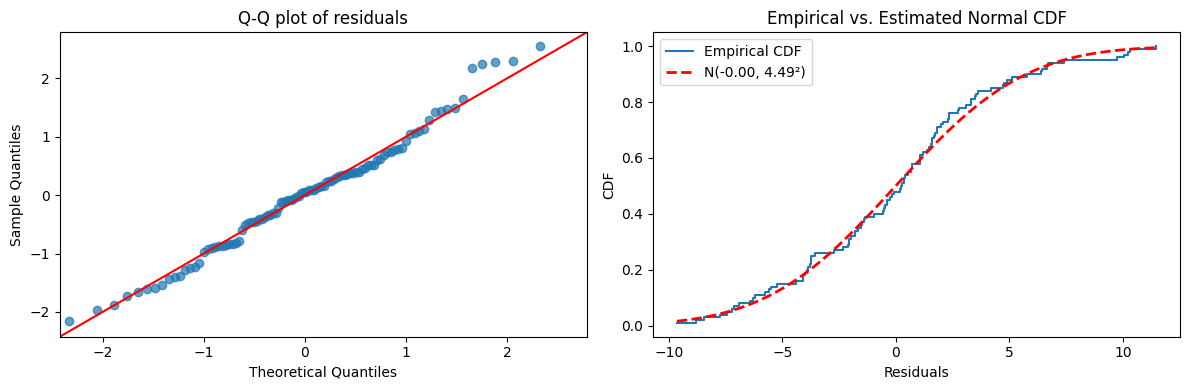

In [5]:
# : Q‑Q plot and ECDF plot with theoretical Normal CDF overlay
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm

# Extract residuals
resid = model.resid
n = len(resid)
sorted_resid = np.sort(resid)
ecdf = np.arange(1, n+1) / n

# MLE estimates for residual distribution
mu_hat = resid.mean()
sigma_hat = np.sqrt(((resid - mu_hat)**2).sum() / n)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Q‑Q plot
sm.qqplot(resid, line='45', fit=True, ax=axes[0], alpha=0.7)
axes[0].set_title('Q‑Q plot of residuals')

# ECDF + theoretical CDF
axes[1].step(sorted_resid, ecdf, where='post', label='Empirical CDF')
x_vals = np.linspace(sorted_resid.min(), sorted_resid.max(), 200)
axes[1].plot(x_vals, norm.cdf(x_vals, loc=mu_hat, scale=sigma_hat),
             'r--', lw=2, label=f'N({mu_hat:.2f}, {sigma_hat:.2f}²)')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('CDF')
axes[1].set_title('Empirical vs. Estimated Normal CDF')
axes[1].legend()

plt.tight_layout()
plt.show()


In [6]:
# bootstrap 95% CIs for intercept & slope
n_boot = 1000
boot_params = np.zeros((n_boot, 2))   # columns: [intercept, slope]

for i in range(n_boot):
    idx = np.random.choice(df.index, size=n, replace=True)
    Xb  = sm.add_constant(df.loc[idx, 'X'])
    yb  = df.loc[idx, 'Y']
    res = sm.OLS(yb, Xb).fit()
    boot_params[i] = res.params.values

ci_int = np.percentile(boot_params[:,0], [2.5, 97.5])
ci_slope = np.percentile(boot_params[:,1], [2.5, 97.5])

print(f"95% CI for intercept: {ci_int}")
print(f"95% CI for slope:     {ci_slope}")


95% CI for intercept: [1.40645579 4.64387478]
95% CI for slope:     [2.45985781 3.05608837]


In [7]:
# Cell 5: hypothesis test H0: slope = 0

